In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
# Lets import all the necessary libraries
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT
from numpy import pi

ibmqfactory.load_account:WARNING:2022-10-29 21:55:34,178: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

In [4]:
def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+ [0])

In [5]:
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

In [6]:
# Storing the eigenvalues in a list
eigen_values = ["11000110", "01001110", "10001101", "11001001", "10000111", "01001011"]

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if eigen_values[index][i] == '1':
            qc.x(eigen[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc

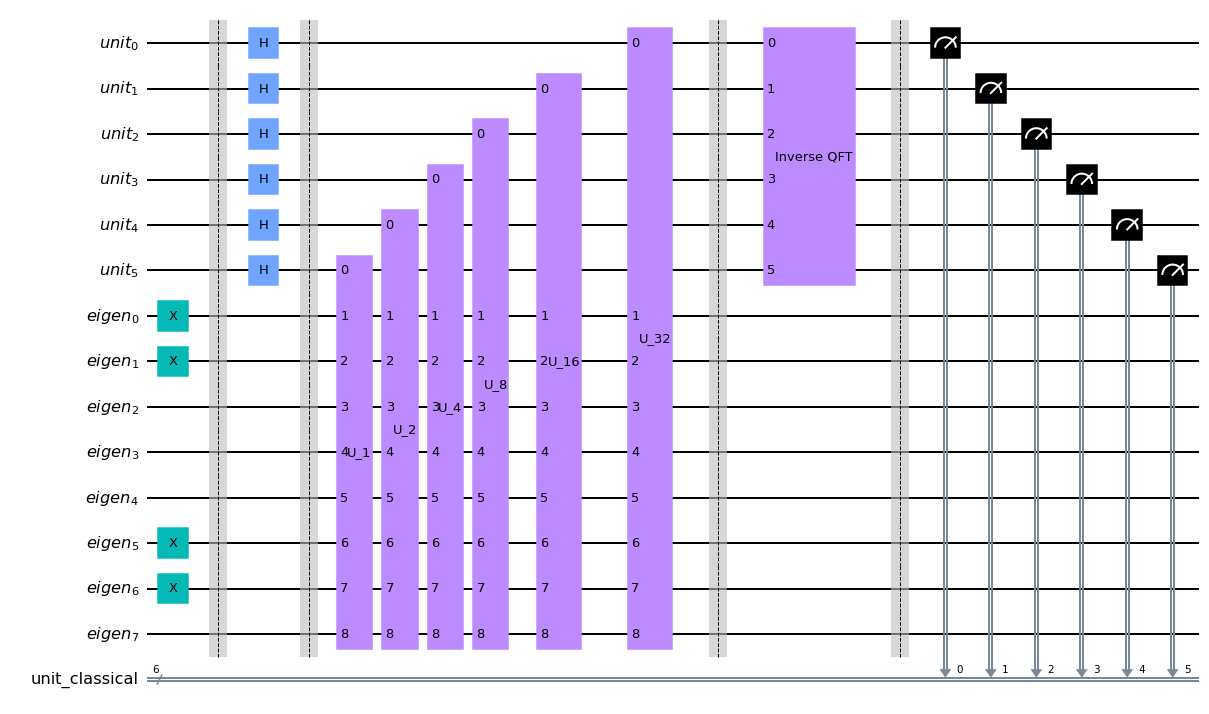

In [7]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 0)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i]] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'100100': 8192}


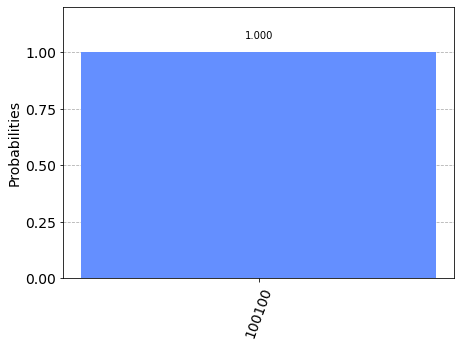

In [8]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)